<a href="https://colab.research.google.com/github/AndrewCDownie/SubmodularDataSelection/blob/master/CS_680_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-tuning BERT via Submodular Maxmization**

Author: Andrew Downie

Email: acdownie@uwaterloo.ca

This is the notebook used to implement the Code for my CS 680 Project

**Initialization**

In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter()
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import time
import torch
import random
from transformers import BertModel, BertConfig,BertForMultipleChoice
import torch
cpu = torch.device("cpu")

if torch.cuda.is_available():
  print("GPU avalible")
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  print("Using CPU")
torch.cuda.empty_cache()
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 15.2MB/s 
     |████████████████████████████████| 890kB 19.8MB/s 
     |████████████████████████████████| 3.0MB 30.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6afe144820aa668f0a4eb96f28a688196843dd6a888b8097df813603ef4cc53e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
GPU avalible
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

In [ ]:
class cloze_data_set(Dataset):
  def __init__(self,file_path,indices = None):
    #open the file
    cloze_test_data = pd.read_csv(file_path)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    #column names
    sentence_cols = ["InputSentence1","InputSentence2","InputSentence3","InputSentence4"]
    endings_cols = ["RandomFifthSentenceQuiz1","RandomFifthSentenceQuiz2"]
    answer_col = "AnswerRightEnding"

    #Initlaize data
    self.stories = []
    self.endings = []
    self.correct_endings = []
    self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case = True)
    self.input_data = []
    self.labels = []
    self.story_encodings = []
    #iterate through rows and get the data 
    for i,row in cloze_test_data.iterrows():
      story = ""
      for col in sentence_cols:
        story += " "+row[col]
      if indices is not None and i not in indices:
        continue
      self.endings.append([row[endings_cols[0]],row[endings_cols[1]]])
      self.stories.append(story)
      self.correct_endings.append(int(row[answer_col])-1)

    #convert the data points to input acceptable data using tokenizer

    for i in range(len(self.stories)):#(len(self.stories)):
      data_point = [[self.stories[i],self.endings[i][0]],[self.stories[i],self.endings[i][1]]]
      label = torch.LongTensor([self.correct_endings[i]])
      encoding = self.tokenizer.batch_encode_plus(data_point,return_tensors="pt",pad_to_max_length=True,max_length = 128,truncation=True)
      data = {k: v.unsqueeze(0) for k,v in encoding.items()}
      self.input_data.append(data)
      self.labels.append(label)
      story_encoding = self.tokenizer.batch_encode_plus([self.stories[i]],return_tensors="pt",pad_to_max_length=True,max_length = 128,truncation=True)
      data = {k: v.unsqueeze(0) for k,v in story_encoding.items()}
      self.story_encodings.append(data)

  #returns the length when len function is used
  def __len__(self):
    return len(self.input_data)
    

  #retrives item if [] opertations are used
  def __getitem__(self,idx):
    return{"input_data":self.input_data[idx],"label":self.labels[idx],"story":self.stories[idx],'story_encoding':self.story_encodings[idx],"endings":self.endings[idx]}

  #function to combine data points into batches when using data loader
  def collate_function(self,batch):
    input_id_tensors = []
    input_ids_sets = []
    token_type_ids_sets = []
    attention_mask_sets = []
    labels = []
    for element in batch:
      input_ids_sets.append(element['input_data']['input_ids'][0])
      token_type_ids_sets.append(element['input_data']['token_type_ids'][0])
      attention_mask_sets.append(element['input_data']['attention_mask'][0])
      labels.append(element['label'][0].item())
      
    return {"input_data":{'input_ids':torch.stack(input_ids_sets),"token_type_ids":torch.stack(token_type_ids_sets),"attention_mask":torch.stack(attention_mask_sets)},'labels':torch.LongTensor(labels)}
  
  #combine the story encodings for batching to find the similarity vectors
  def collate_function_story_encoding(self,batch):
    input_id_tensors = []
    input_ids_sets = []
    token_type_ids_sets = []
    attention_mask_sets = []
    labels = []
    for element in batch:
      #print(element['story_encoding']['input_ids'][0][0].size())
      input_ids_sets.append(element['story_encoding']['input_ids'][0][0])
      token_type_ids_sets.append(element['story_encoding']['token_type_ids'][0][0])
      attention_mask_sets.append(element['story_encoding']['attention_mask'][0][0])
      labels.append(element['label'][0].item())
      
    return {"input_data":{'input_ids':torch.stack(input_ids_sets),"token_type_ids":torch.stack(token_type_ids_sets),"attention_mask":torch.stack(attention_mask_sets)},'labels':torch.LongTensor(labels)}

    #for input_data in 


**Training Functions**

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def get_pred(logits):
  np_logits = logits.cpu().detach().numpy()
  pred = np.argmax(np_logits)
  return pred

def run_test(model,test_set,device,cpu):
  #given model, test set and device run the test on the test_set and report accuracy and total loss
  correct = 0
  total_complete = 0
  total_loss = 0
  model.eval()
  #loop through batches and calculate the number of correct predictions
  for i,batch in enumerate(test_set):

    #send the data to the GPU
    input_ids = batch['input_data']['input_ids'].to(device)
    token_type_ids = batch['input_data']['token_type_ids'].to(device)
    attention_mask = batch['input_data']['attention_mask'].to(device)
    labels= batch['labels'].to(device)

    #compute Prediction
    with torch.no_grad():
      (loss,logits) = model(input_ids = input_ids,token_type_ids = token_type_ids,attention_mask = attention_mask, labels= labels)
    total_loss += loss.item()
    for i,logit in enumerate(logits):
      prediction = get_pred(logit)
      total_complete +=1
      if prediction == labels[i]:
        correct +=1

    #remove data from GPU
    input_ids.cpu()
    token_type_ids.cpu()
    attention_mask.cpu()
    labels= batch['labels'].cpu()
  return (1.0*correct/total_complete,total_loss)

def train_model(model,data_set,test_set,device,cpu,epochs):
  #initalize optimizer and schedualer
  tic = time.perf_counter()
  optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
  total_steps = len(data_set) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  accuracies = []
  #loop through epochs defined
  for epoch in range(epochs):
    total_loss = 0
    model.train()

    #loop through batches of data
    for i,batch in enumerate(data_set):

      #write to device
      input_ids = batch['input_data']['input_ids'].to(device)
      token_type_ids = batch['input_data']['token_type_ids'].to(device)
      attention_mask = batch['input_data']['attention_mask'].to(device)
      labels= batch['labels'].to(device)
      
      #calculate losses
      (loss,logits) = model(input_ids = input_ids,token_type_ids = token_type_ids,attention_mask = attention_mask, labels= labels)
      total_loss += loss.item()

      #compute gradients and update model
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),1)
      optimizer.step()
      scheduler.step()

      #remove data from device
      input_ids.cpu()
      token_type_ids.cpu()
      attention_mask.cpu()
      labels.cpu()
    
    #run test on the model
    print("total_loss:",total_loss)
    (test_accuracy,test_loss) = run_test(model,test_set,device,cpu)
    accuracies.append(test_accuracy)
    print("test accuracy: {}, test_loss: {}".format(test_accuracy,test_loss))
  toc = time.perf_counter()
  print("time:",toc-tic)
  return accuracies


In [ ]:
torch.cuda.empty_cache()

In [ ]:

def generate_story_vectors_using_bert(model_,file_path,indices = None):
  #Load the Data Set
  print("loading data set")
  train_set = cloze_data_set(file_path,indices = indices)
  train_loader = torch.utils.data.DataLoader(train_set,batch_size = 32,collate_fn=train_set.collate_function_story_encoding)
  print("Loading Complete")
  print("size of data set:",len(train_set))

  #Start Counter and Initialize variables
  tic = time.perf_counter()
  initialized = False
  story_vectors = None
  #loop through the batches and computer the data
  for i,batch in enumerate(train_loader):
    if (i+1) %100 == 0:
      print("batches compled:",i)

    #send data to GPU
    input_ids = batch['input_data']['input_ids'].to(device)
    token_type_ids = batch['input_data']['token_type_ids'].to(device)
    attention_mask = batch['input_data']['attention_mask'].to(device)
    labels= batch['labels'].to(device)

    #compute output without gradients and grab the pooled data using mean pooling
    with torch.no_grad():
      output = model_(input_ids = input_ids,token_type_ids = token_type_ids,attention_mask = attention_mask,output_hidden_states=True)
      pooled = torch.mean(output[0][0],0,True)
      for element in output[0][1:]:
        #pool = torch.mean(element,0,True)
        pooled = torch.cat((pooled,torch.mean(element,0,True)),0)

      #off load the gpu
      output_cpu = pooled.cpu()

    #stack the output into large tensor for processing 
    if not initialized:
      print(output_cpu.size())
      story_vectors = output_cpu
      initialized = True
    else:
      story_vectors = torch.cat((story_vectors,output_cpu),0)
  toc = time.perf_counter()
  print(story_vectors.size())
  print("time to complete:",toc-tic)
  return story_vectors

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi


Tue Aug  4 17:34:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    31W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
def get_sim_matrix(story_vectors):
  tic = time.perf_counter()
  #vectors = story_vectors.to(device)
  story_norms  = torch.norm(story_vectors,dim=1)
  for i in range(len(story_vectors)):
    story_vectors[i] = story_vectors[i].div(story_norms[i]) 
  toc = time.perf_counter()
  print("time to compute norms:",toc-tic)
  tic = time.perf_counter()
  E = story_vectors.to(device)
  tic = time.perf_counter()
  V = E @ E.t()
  toc = time.perf_counter()
  print("time to compute matrix:",toc-tic)
  return V

def select_elements(E,k,l):
  tic_total = time.perf_counter()
  n = E.size()[0]
  e = torch.ones(n,1,device=device)
  tic_ = time.perf_counter()
  #marginals = (1/n)*(E @ e)
  U = E @ e
  L = torch.zeros(n,1,device=device)
  losses = torch.zeros(n,1,device=device)
  marginals = U - L
  toc_ = time.perf_counter()
  s = torch.argmax(marginals).item()
  marginals[s,0] = 0
  U[s,0] = -1000
  L[s,0] = -1000
  losses[s,0] = -1000
  S = [s]
  V_S = list(range(n)) 
  V_S.remove(s)
  for i in range(1,k):
    new_sims = torch.stack([E[:,s]],dim = 1)
    U -= new_sims
    L += new_sims 
    losses += l*new_sims

    marginals =U - L - (l)*losses
    tic = time.perf_counter()
    s = torch.argmax(marginals).item()
    U[s,0] = -1000
    L[s,0] = -1000
    toc = time.perf_counter()
    S.append(s)
  toc_total = time.perf_counter()
  print("computed",k,"in",toc_total-tic_total)
  return S

def select_elements_old(E,k,l):
  tic_total = time.perf_counter()
  n = E.size()[0]
  e = torch.ones(n,1,device=device)
  tic_ = time.perf_counter()
  marginals = (1/n)*(E @ e)
  toc_ = time.perf_counter()
  s = torch.argmax(marginals).item()
  marginals[s,0] = 0
  S = [s]
  V_S = list(range(n)) 
  V_S.remove(s)
  for i in range(1,k):
    marginals -=(1+l)*torch.stack([E[:,s]],dim = 1)
    tic = time.perf_counter()
    s = torch.argmax(marginals).item()
    marginals[s,0] = -1000
    toc = time.perf_counter()
    S.append(s)
  toc_total = time.perf_counter()
  print("computed",k,"in",toc_total-tic_total)

  return S




In [ ]:
print("loading Test Loader data")
file_path_test = "drive/My Drive/CS 680 Project/cloze_test_test__spring2016 - cloze_test_ALL_test.csv"
file_path_train = "drive/My Drive/CS 680 Project/generated_dataset_3.csv"
file_path_val = "drive/My Drive/CS 680 Project/cloze_test_val__spring2016 - cloze_test_ALL_val.csv"
file_path_val = "drive/My Drive/CS 680 Project/winter_2018_val.csv"
file_path_val = "drive/My Drive/CS 680 Project/redundant_data_set_1_100.csv"

#refined_data_set = cloze_data_set(file_path_val,indices = S)
#random_data_set = cloze_data_set(file_path_val,indices = range(1500))#,indices = random_S)
test_set = cloze_data_set(file_path_test)


#refined_train_loader = DataLoader(refined_data_set,batch_size = 16,collate_fn=refined_data_set.collate_function)
#random_train_loader = DataLoader(random_data_set,batch_size = 16,collate_fn=random_data_set.collate_function)
test_loader = DataLoader(test_set,batch_size = 16,collate_fn=test_set.collate_function)
print("done loading Data set")

loading Test Loader data



done loading Data set


In [ ]:
!pip install gensim
import gensim

Full Model Training:

In [ ]:
full_data_set = cloze_data_set(file_path_val)
full_data_set_loader = DataLoader(full_data_set,batch_size = 16,collate_fn=full_data_set.collate_function)


In [ ]:

#train model

configuration = BertConfig()
print("Running Full Model Training")
torch.manual_seed(0)
fullModel = BertForMultipleChoice.from_pretrained("bert-base-uncased")
fullModel.cuda()
fullModel.train()
print("refined test",run_test(fullModel,test_loader,device,cpu))
tic = time.perf_counter()
full_accuracies = train_model(fullModel,full_data_set_loader,test_loader,device,cpu,5)
toc = time.perf_counter()
print("Full Accuracies",full_accuracies)

#free up memory for the model
del fullModel

Running Full Model Training


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

refined test (0.48690539818278994, 81.68855518102646)
total_loss: 61.64616894040546
test accuracy: 0.7183324425440941, test_loss: 135.40818312764168
total_loss: 55.657720672406356
test accuracy: 0.6825227151256013, test_loss: 94.32538306713104
total_loss: 55.37911007514775
test accuracy: 0.7006948156066275, test_loss: 176.5616859048605
total_loss: 51.265087577965545
test accuracy: 0.6686264029930519, test_loss: 247.19418866932392
total_loss: 104.40747425801595
test accuracy: 0.7616247995724211, test_loss: 175.1657616943121
time: 946.1796539650004
Full Accuracies [0.7183324425440941, 0.6825227151256013, 0.7006948156066275, 0.6686264029930519, 0.7616247995724211]


In [ ]:
tic = time.perf_counter()
gensim_model = gensim.models.doc2vec.Doc2Vec(vector_size = 100,min_count =2 ,epochs = 40)

text_corpus = []
gensim_tokenized = []
for i,story in enumerate(full_data_set.stories):
  tokens = gensim.utils.simple_preprocess(story)
  gensim_tokenized.append(tokens)
  text_corpus.append(gensim.models.doc2vec.TaggedDocument(tokens, [i]))

print("generating corpus")
gensim_model.build_vocab(text_corpus)
gensim_model.train(text_corpus,total_examples=gensim_model.corpus_count,epochs = gensim_model.epochs)
gensim_vectors = []
print("generating vectors")
for tokens in gensim_tokenized:
  gensim_vectors.append(gensim_model.infer_vector(tokens))

gensim_vectors = np.stack(gensim_vectors)

gensim_vectors = torch.from_numpy(gensim_vectors)
toc = time.perf_counter()

print("Time To Compute Gensim Embeddings ",toc-tic)

generating corpus
generating vectors
Time To Compute Gensim Embeddings  46.834745743999974


In [ ]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
model.cuda()

bert_story_vectors = generate_story_vectors_using_bert(model,file_path_val)



loading data set
Loading Complete
size of data set: 3671
torch.Size([32, 768])
batches compled: 99
torch.Size([3671, 768])
time to complete: 25.177850074000048


In [ ]:
def train_model_vectors(bert_story_vectors, size, file_path,l):
  #calculate the sim matrix
  E = get_sim_matrix(bert_story_vectors)
  
  #select elements
  S = select_elements(E,size,l)

  #generate bert data set and train model
  refined_set_bert = cloze_data_set(file_path,indices= S)
  refined_loader_bert = DataLoader(refined_set_bert,batch_size = 16,collate_fn=refined_set_bert.collate_function)
  torch.manual_seed(0)
  refined_bert_model = BertForMultipleChoice.from_pretrained("bert-base-uncased")
  refined_bert_model.cuda()
  refined_bert_model.train()
  #print("refined test",run_test(refined_bert_model,test_loader,device,cpu))
  tic = time.perf_counter()
  accuracies = train_model(refined_bert_model,refined_loader_bert,test_loader,device,cpu,5)
  toc = time.perf_counter()
  print("Accuracies",accuracies)
  
  del refined_bert_model
  return accuracies,toc-tic

def train_model_random(data_set_size,size,file_path):
  
  #select elements
  S = random.sample(list(range(data_set_size)),size)

  #generate bert data set and train model
  refined_set_bert = cloze_data_set(file_path,indices= S)
  refined_loader_bert = DataLoader(refined_set_bert,batch_size = 16,collate_fn=refined_set_bert.collate_function)
  torch.manual_seed(0)
  refined_bert_model = BertForMultipleChoice.from_pretrained("bert-base-uncased")
  refined_bert_model.cuda()
  refined_bert_model.train()
  #print("refined test",run_test(refined_bert_model,test_loader,device,cpu))
  tic = time.perf_counter()
  accuracies = train_model(refined_bert_model,refined_loader_bert,test_loader,device,cpu,5)
  toc = time.perf_counter()
  print("Accuracies",accuracies)
  
  del refined_bert_model
  return accuracies, toc-tic


In [ ]:
#TEST STRUCTURE
#generate Vector Sets

#sizes = [100,100,300]
#sizes = [50,100]
bert_story_vector_accuracy_sets = []
gensim_story_vector_accuracy_sets = []
random_accuracy_sets = []

bert_times = []
gensim_times= []
random_times = []

size_of_total_data_set = len(full_data_set)
l = 2
#LOOP THROUGH sizes 
sizes = [100,250,300] #,750,1000,2000]
sizes = [int(0.05*size_of_total_data_set), int(0.1*size_of_total_data_set), int(0.25*size_of_total_data_set),int(0.4*size_of_total_data_set),int(0.6*size_of_total_data_set),int(0.8*size_of_total_data_set)]
for size in sizes:
  #calculate the sim matrix
  print("EXECUTING BERT EMBEDDINGS:",size)
  bert_accuracies,time_to_execute = train_model_vectors(bert_story_vectors,size,file_path_val,l)
  bert_times.append(time_to_execute)
  bert_story_vector_accuracy_sets.append(bert_accuracies)

  print("EXECUTING GENSIM EMBEDDINGS:",size)
  gensim_accuracies,time_to_execute = train_model_vectors(gensim_vectors,size,file_path_val,l)
  gensim_times.append(time_to_execute)
  gensim_story_vector_accuracy_sets.append(gensim_accuracies)

  print("RANDOM EMBEDDINGS:",size)
  random_accuracy,time_to_execute = train_model_random(size_of_total_data_set,size,file_path_val)
  random_times.append(time_to_execute)
  random_accuracy_sets.append(random_accuracy)
  """"
  E = get_sim_matrix(bert_story_vectors)
  
  #select elements
  S = select_elements(E,size)

  #generate bert data set and train model
  refined_set_bert = cloze_data_set(file_path_val,indices= S)
  refined_loader_bert = DataLoader(refined_set_bert,batch_size = 16,collate_fn=refined_set_bert.collate_function)
  torch.manual_seed(0)
  refined_bert_model = BertForMultipleChoice.from_pretrained("bert-base-uncased")
  refined_bert_model.cuda()
  refined_bert_model.train()
  print("refined test",run_test(refined_bert_model,test_loader,device,cpu))
  tic = time.perf_counter()
  bert_accuracies = train_model(refined_bert_model,refined_loader_bert,test_loader,device,cpu,5)
  toc = time.perf_counter()
  print("Bert Accuracies",bert_accuracies)
  bert_story_vector_accuracy_sets.append(bert_accuracies)
  del refined_bert_model
  #for each type of embedding [Bert, Gensim, Inverse Doc sum]
    #calculate set
    #Train model and record time and accuracies and losses
  """
  


EXECUTING BERT EMBEDDINGS: 183
time to compute norms: 0.06479687700084469
time to compute matrix: 0.00010753500009741401
computed 183 in 0.04941087499992136


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 8.345449209213257
test accuracy: 0.635489043292357, test_loss: 80.10847717523575
total_loss: 8.50364226102829
test accuracy: 0.669695350080171, test_loss: 78.16710585355759
total_loss: 7.674431502819061
test accuracy: 0.6884019241047569, test_loss: 75.40489727258682
total_loss: 6.8161099553108215
test accuracy: 0.7124532335649385, test_loss: 72.79189801216125
total_loss: 6.095380574464798
test accuracy: 0.721004810261892, test_loss: 71.74053072929382
time: 185.1752102620003
Accuracies [0.635489043292357, 0.669695350080171, 0.6884019241047569, 0.7124532335649385, 0.721004810261892]
EXECUTING GENSIM EMBEDDINGS: 183
time to compute norms: 0.042534041999715555
time to compute matrix: 7.493500015698373e-05
computed 183 in 0.047211836999849766


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 7.5939309895038605
test accuracy: 0.5964724746125066, test_loss: 80.4588611125946
total_loss: 4.864193856716156
test accuracy: 0.5793693212185996, test_loss: 80.79020392894745
total_loss: 1.8332729637622833
test accuracy: 0.6050240513094601, test_loss: 83.14679896831512
total_loss: 0.7929576318711042
test accuracy: 0.5718866916087654, test_loss: 89.65050262212753
total_loss: 0.3848968604579568
test accuracy: 0.5836451095670764, test_loss: 95.16199386119843
time: 185.2243679410003
Accuracies [0.5964724746125066, 0.5793693212185996, 0.6050240513094601, 0.5718866916087654, 0.5836451095670764]
RANDOM EMBEDDINGS: 183


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 8.35550320148468
test accuracy: 0.6199893105291288, test_loss: 80.96173572540283
total_loss: 8.120988845825195
test accuracy: 0.6643506146445751, test_loss: 78.07979089021683
total_loss: 7.0153356194496155
test accuracy: 0.6675574559059326, test_loss: 75.43654888868332
total_loss: 6.005118668079376
test accuracy: 0.6782469267771245, test_loss: 73.10038435459137
total_loss: 5.1736438274383545
test accuracy: 0.6889363976483164, test_loss: 72.16860717535019
time: 185.13993394200043
Accuracies [0.6199893105291288, 0.6643506146445751, 0.6675574559059326, 0.6782469267771245, 0.6889363976483164]
EXECUTING BERT EMBEDDINGS: 367
time to compute norms: 0.03936514199995145
time to compute matrix: 6.167399988044053e-05
computed 367 in 0.07871585300017614


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 15.741864025592804
test accuracy: 0.721004810261892, test_loss: 75.64100557565689
total_loss: 11.629179134964943
test accuracy: 0.7883484767504009, test_loss: 63.076546400785446
total_loss: 7.386884205043316
test accuracy: 0.7846071619454837, test_loss: 55.90557950735092
total_loss: 4.538437288254499
test accuracy: 0.8049171566007483, test_loss: 51.184275686740875
total_loss: 2.981687568128109
test accuracy: 0.8049171566007483, test_loss: 50.566743582487106
time: 225.4717633149994
Accuracies [0.721004810261892, 0.7883484767504009, 0.7846071619454837, 0.8049171566007483, 0.8049171566007483]
EXECUTING GENSIM EMBEDDINGS: 367
time to compute norms: 0.04016039799989812
time to compute matrix: 7.873199956520693e-05
computed 367 in 0.08637833899956604


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 12.790741503238678
test accuracy: 0.5921966862640299, test_loss: 79.09170109033585
total_loss: 2.212381722405553
test accuracy: 0.5873864243719936, test_loss: 97.89436280727386
total_loss: 0.09063220367534086
test accuracy: 0.5911277391769107, test_loss: 121.60493439435959
total_loss: 0.06237620074534789
test accuracy: 0.6098343132014965, test_loss: 123.99493782222271
total_loss: 0.026651938824215904
test accuracy: 0.6312132549438803, test_loss: 138.75349208712578
time: 225.24098786499962
Accuracies [0.5921966862640299, 0.5873864243719936, 0.5911277391769107, 0.6098343132014965, 0.6312132549438803]
RANDOM EMBEDDINGS: 367


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 15.693734765052795
test accuracy: 0.6990913949759487, test_loss: 77.6158259510994
total_loss: 11.625577479600906
test accuracy: 0.7423837520042758, test_loss: 66.09393271803856
total_loss: 6.112415574491024
test accuracy: 0.755211117049706, test_loss: 59.827634036540985
total_loss: 3.0771202947944403
test accuracy: 0.760555852485302, test_loss: 59.653732895851135
total_loss: 1.9244315335527062
test accuracy: 0.7765900587920898, test_loss: 56.63444845378399
time: 225.8691451500008
Accuracies [0.6990913949759487, 0.7423837520042758, 0.755211117049706, 0.760555852485302, 0.7765900587920898]
EXECUTING BERT EMBEDDINGS: 917
time to compute norms: 0.061338387000432704
time to compute matrix: 0.00010759799988591112
computed 917 in 0.2610305009993681


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 33.895597741007805
test accuracy: 0.7771245323356494, test_loss: 57.618194937705994
total_loss: 15.199880097061396
test accuracy: 0.8209513629075361, test_loss: 47.573180355131626
total_loss: 4.687062938231975
test accuracy: 0.8423303046499199, test_loss: 43.543661803007126
total_loss: 2.1505541016813368
test accuracy: 0.8140032068412614, test_loss: 54.17332972586155
total_loss: 1.3433208623318933
test accuracy: 0.840726884019241, test_loss: 49.263020699843764
time: 345.72979047899935
Accuracies [0.7771245323356494, 0.8209513629075361, 0.8423303046499199, 0.8140032068412614, 0.840726884019241]
EXECUTING GENSIM EMBEDDINGS: 917
time to compute norms: 0.034383506000267516
time to compute matrix: 7.656900015717838e-05
computed 917 in 0.18563735199950315


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 22.544557824730873
test accuracy: 0.7183324425440941, test_loss: 69.8348146378994
total_loss: 9.022884760051966
test accuracy: 0.7616247995724211, test_loss: 60.4938562810421
total_loss: 3.696459149941802
test accuracy: 0.7653661143773384, test_loss: 65.07464745640755
total_loss: 1.4591385027160868
test accuracy: 0.7520042757883485, test_loss: 61.96685929596424
total_loss: 1.0456669686245732
test accuracy: 0.7781934794227686, test_loss: 62.11329337954521
time: 277.43789278999975
Accuracies [0.7183324425440941, 0.7616247995724211, 0.7653661143773384, 0.7520042757883485, 0.7781934794227686]
RANDOM EMBEDDINGS: 917


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 28.795616693794727
test accuracy: 0.7471940138963121, test_loss: 59.26089629530907
total_loss: 10.968017319450155
test accuracy: 0.7642971672902191, test_loss: 75.95533420145512
total_loss: 3.3866801383701386
test accuracy: 0.7819347942276857, test_loss: 70.94413775205612
total_loss: 2.483172928186832
test accuracy: 0.7685729556386959, test_loss: 104.80698199570179
total_loss: 2.674843068314658
test accuracy: 0.8166755745590594, test_loss: 72.14424538612366
time: 346.00834809500066
Accuracies [0.7471940138963121, 0.7642971672902191, 0.7819347942276857, 0.7685729556386959, 0.8166755745590594]
EXECUTING BERT EMBEDDINGS: 1468
time to compute norms: 0.06307684899911692
time to compute matrix: 0.00012153799980296753
computed 1468 in 0.31637720899925625


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 39.645123563241214
test accuracy: 0.760555852485302, test_loss: 63.2176381573081
total_loss: 15.163134466820338
test accuracy: 0.7306253340459647, test_loss: 146.14675444364548
total_loss: 12.170655628608984
test accuracy: 0.7226082308925709, test_loss: 187.29659235477448
total_loss: 21.498406571798114
test accuracy: 0.8113308391234634, test_loss: 64.99518848210573
total_loss: 5.466681188539042
test accuracy: 0.8327097808658471, test_loss: 75.73674572631717
time: 467.04850017600074
Accuracies [0.760555852485302, 0.7306253340459647, 0.7226082308925709, 0.8113308391234634, 0.8327097808658471]
EXECUTING GENSIM EMBEDDINGS: 1468
time to compute norms: 0.0350594440005807
time to compute matrix: 8.904700007406063e-05
computed 1468 in 0.3002268799991725


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 26.92233330756426
test accuracy: 0.7482629609834314, test_loss: 60.64911609888077
total_loss: 10.495694520883262
test accuracy: 0.806520577231427, test_loss: 53.67845977842808
total_loss: 3.3539883906487375
test accuracy: 0.8011758417958311, test_loss: 59.57536079734564
total_loss: 1.6794466029386967
test accuracy: 0.8225547835382149, test_loss: 53.04937334358692
total_loss: 1.3412769643764477
test accuracy: 0.8311063602351684, test_loss: 56.84062331914902
time: 316.95100833700053
Accuracies [0.7482629609834314, 0.806520577231427, 0.8011758417958311, 0.8225547835382149, 0.8311063602351684]
RANDOM EMBEDDINGS: 1468


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 39.458706992911175
test accuracy: 0.7060395510422234, test_loss: 91.04347153007984
total_loss: 21.262688921189692
test accuracy: 0.6648850881881346, test_loss: 102.06199452280998
total_loss: 23.537234224041413
test accuracy: 0.6659540352752539, test_loss: 219.5886343717575
total_loss: 40.16835312077092
test accuracy: 0.6595403527525387, test_loss: 118.69114539027214
total_loss: 31.308218615242367
test accuracy: 0.721004810261892, test_loss: 109.59519273042679
time: 466.4883605590003
Accuracies [0.7060395510422234, 0.6648850881881346, 0.6659540352752539, 0.6595403527525387, 0.721004810261892]
EXECUTING BERT EMBEDDINGS: 2202
time to compute norms: 0.04739662199972372
time to compute matrix: 8.59179999679327e-05
computed 2202 in 0.4488559500005067


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 44.80680343846325
test accuracy: 0.7739176910742919, test_loss: 71.03771933913231
total_loss: 17.38906196638709
test accuracy: 0.7108498129342598, test_loss: 136.13756407797337
total_loss: 19.60917184429718
test accuracy: 0.726349545697488, test_loss: 190.61177945137024
total_loss: 25.356306672213236
test accuracy: 0.7985034740780331, test_loss: 73.84839956462383
total_loss: 11.97928104871744
test accuracy: 0.840726884019241, test_loss: 64.57768112793565
time: 549.5790873920014
Accuracies [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241]
EXECUTING GENSIM EMBEDDINGS: 2202
time to compute norms: 0.04338753299998643
time to compute matrix: 0.00018685000031837262
computed 2202 in 0.4517217359989445


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 32.47706034779549
test accuracy: 0.7487974345269909, test_loss: 58.962018966674805
total_loss: 12.817118262406439
test accuracy: 0.7958311063602351, test_loss: 59.90970914065838
total_loss: 4.48296576627763
test accuracy: 0.8385889898450026, test_loss: 50.301954843103886
total_loss: 2.0671919195738155
test accuracy: 0.7691074291822555, test_loss: 91.63265597075224
total_loss: 4.187460323955747
test accuracy: 0.8284339925173704, test_loss: 64.25320582836866
time: 354.6789590729986
Accuracies [0.7487974345269909, 0.7958311063602351, 0.8385889898450026, 0.7691074291822555, 0.8284339925173704]
RANDOM EMBEDDINGS: 2202


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 47.60878222330939
test accuracy: 0.7926242650988776, test_loss: 67.3228260204196
total_loss: 21.83566197964683
test accuracy: 0.7076429716729022, test_loss: 128.0226545035839
total_loss: 21.301473742931194
test accuracy: 0.7728487439871726, test_loss: 77.00634422153234
total_loss: 12.80824289166867
test accuracy: 0.814537680384821, test_loss: 82.98098056577146
total_loss: 8.911600607511218
test accuracy: 0.7985034740780331, test_loss: 118.46155947633088
time: 627.2101291769995
Accuracies [0.7926242650988776, 0.7076429716729022, 0.7728487439871726, 0.814537680384821, 0.7985034740780331]
EXECUTING BERT EMBEDDINGS: 2936
time to compute norms: 0.04832364299909386
time to compute matrix: 0.00020167700131423771
computed 2936 in 0.5913693459988281


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 44.80680343846325
test accuracy: 0.7739176910742919, test_loss: 71.03771933913231
total_loss: 17.38906196638709
test accuracy: 0.7108498129342598, test_loss: 136.13756407797337
total_loss: 19.60917184429718
test accuracy: 0.726349545697488, test_loss: 190.61177945137024
total_loss: 25.356306672213236
test accuracy: 0.7985034740780331, test_loss: 73.84839956462383
total_loss: 11.97928104871744
test accuracy: 0.840726884019241, test_loss: 64.57768112793565
time: 549.242411786001
Accuracies [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241]
EXECUTING GENSIM EMBEDDINGS: 2936
time to compute norms: 0.03787502500017581
time to compute matrix: 8.716999946045689e-05
computed 2936 in 0.610856335999415


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 37.72321426123381
test accuracy: 0.7824692677712454, test_loss: 54.265728414058685
total_loss: 14.704051952809095
test accuracy: 0.8241582041688936, test_loss: 51.66719615459442
total_loss: 3.647600490716286
test accuracy: 0.8450026723677178, test_loss: 51.876585371792316
total_loss: 1.558629198341805
test accuracy: 0.8156066274719401, test_loss: 59.04691532254219
total_loss: 3.245459076068073
test accuracy: 0.8546231961517905, test_loss: 51.7740085683763
time: 390.0002696319989
Accuracies [0.7824692677712454, 0.8241582041688936, 0.8450026723677178, 0.8156066274719401, 0.8546231961517905]
RANDOM EMBEDDINGS: 2936


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

total_loss: 48.857717841048725
test accuracy: 0.6835916622127205, test_loss: 173.17070242762566
total_loss: 34.977137259771894
test accuracy: 0.7183324425440941, test_loss: 182.8070441186428
total_loss: 42.17477009215625
test accuracy: 0.6787814003206841, test_loss: 156.7620723694563
total_loss: 47.126299343357914
test accuracy: 0.7028327097808659, test_loss: 248.5514266192913
total_loss: 62.67930879069331
test accuracy: 0.8241582041688936, test_loss: 76.62251862511039
time: 788.3104846709994
Accuracies [0.6835916622127205, 0.7183324425440941, 0.6787814003206841, 0.7028327097808659, 0.8241582041688936]


In [ ]:
print(bert_story_vector_accuracy_sets)

[[0.7765900587920898, 0.8311063602351684, 0.8450026723677178, 0.8439337252805986, 0.848743987172635], [0.809192944949225, 0.826296098343132, 0.8359166221272047, 0.8428647781934794, 0.8375200427578835], [0.8450026723677178, 0.8503474078033137, 0.8722608230892571, 0.8642437199358631, 0.8663816141101015], [0.8450026723677178, 0.8503474078033137, 0.8722608230892571, 0.8642437199358631, 0.8663816141101015]]


RUN THE FOLLOWING IF YOU WANT TO SAVE THE DATA FROM THE EXECUTION

In [ ]:
import pickle
data_frame = {"sizes":sizes,
              "bert_story_vector_accuracy_sets":bert_story_vector_accuracy_sets,
              "gensim_story_vector_accuracy_sets":gensim_story_vector_accuracy_sets,
              "random_accuracy_sets":random_accuracy_sets
              }
with open("drive/My Drive/CS 680 Project/results.pkl",'wb') as f:
  pickle.dump(data_frame,f)




In [ ]:
import pickle

with open("drive/My Drive/CS 680 Project/results.pkl",'rb') as f:
  data_from_pickle = pickle.load(f)
print(data_from_pickle)
sizes = data_from_pickle["sizes"]
bert_story_vector_accuracy_sets = data_from_pickle["bert_story_vector_accuracy_sets"]
gensim_story_vector_accuracy_sets = data_from_pickle["gensim_story_vector_accuracy_sets"]
random_accuracy_sets = data_from_pickle["random_accuracy_sets"]

{'sizes': [183, 367, 917, 1468, 2202, 2936], 'bert_story_vector_accuracy_sets': [[0.635489043292357, 0.669695350080171, 0.6884019241047569, 0.7124532335649385, 0.721004810261892], [0.721004810261892, 0.7883484767504009, 0.7846071619454837, 0.8049171566007483, 0.8049171566007483], [0.7771245323356494, 0.8209513629075361, 0.8423303046499199, 0.8140032068412614, 0.840726884019241], [0.760555852485302, 0.7306253340459647, 0.7226082308925709, 0.8113308391234634, 0.8327097808658471], [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241], [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241]], 'gensim_story_vector_accuracy_sets': [[0.5964724746125066, 0.5793693212185996, 0.6050240513094601, 0.5718866916087654, 0.5836451095670764], [0.5921966862640299, 0.5873864243719936, 0.5911277391769107, 0.6098343132014965, 0.6312132549438803], [0.7183324425440941, 0.7616247995724211, 0.7653661143773384, 0.75200427578

In [ ]:
print(bert_story_vector_accuracy_sets)
percents = [5,10,25,40,60,80]
for i in range(len(bert_story_vector_accuracy_sets)):

  formated = "{:.1f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(percents[i],bert_story_vector_accuracy_sets[i][4]*100,gensim_story_vector_accuracy_sets[i][4]*100,random_accuracy_sets[i][4]*100)
  print(formated)
  print("\\hline")
  """
  print(bert_story_vector_accuracy_sets[i][4],"&",gensim_story_vector_accuracy_sets[i][4],)
  print("bert",bert_story_vector_accuracy_sets[i][4])
  print("gensim",gensim_story_vector_accuracy_sets[i][4])
  print("random",random_accuracy_sets[i][4])
  """


[[0.635489043292357, 0.669695350080171, 0.6884019241047569, 0.7124532335649385, 0.721004810261892], [0.721004810261892, 0.7883484767504009, 0.7846071619454837, 0.8049171566007483, 0.8049171566007483], [0.7771245323356494, 0.8209513629075361, 0.8423303046499199, 0.8140032068412614, 0.840726884019241], [0.760555852485302, 0.7306253340459647, 0.7226082308925709, 0.8113308391234634, 0.8327097808658471], [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241], [0.7739176910742919, 0.7108498129342598, 0.726349545697488, 0.7985034740780331, 0.840726884019241]]
5.0 & 72.10 & 58.36 & 68.89 \\
\hline
10.0 & 80.49 & 63.12 & 77.66 \\
\hline
25.0 & 84.07 & 77.82 & 81.67 \\
\hline
40.0 & 83.27 & 83.11 & 72.10 \\
\hline
60.0 & 84.07 & 82.84 & 79.85 \\
\hline
80.0 & 84.07 & 85.46 & 82.42 \\
\hline


Tuning L


In [ ]:
size = 500

ls = [0.2*i for i in range(5)]

bert_accuracies_l = []
gensim_accuracies_l = []

for l in ls:
  bert_accuracy,_ = train_model_vectors(bert_story_vectors,size,file_path_val,l)
  bert_accuracies_l.append(bert_accuracy)

  gensim_accuracy,_ = train_model_vectors(gensim_vectors,size,file_path_val,l)
  gensim_accuracies_l.append(gensim_accuracy)


  

In [ ]:
!nvidia-smi

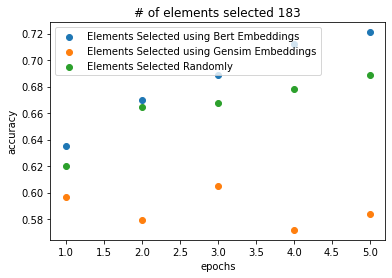

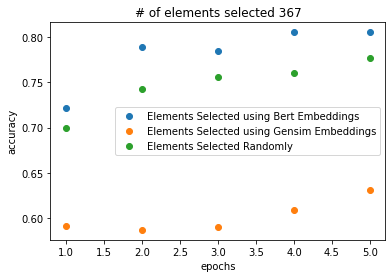

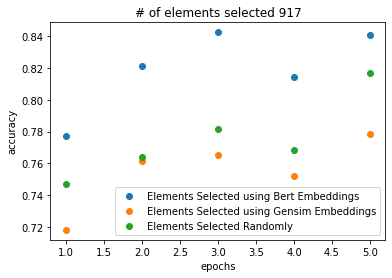

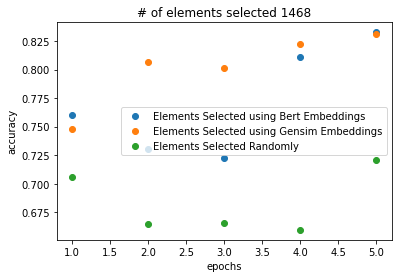

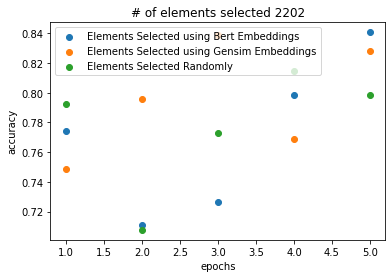

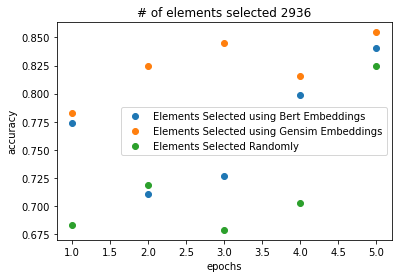

In [ ]:
import matplotlib.pyplot as plt
for i,size in enumerate(sizes):
  plt.figure()
  plt.scatter([1,2,3,4,5],bert_story_vector_accuracy_sets[i])
  plt.scatter([1,2,3,4,5],gensim_story_vector_accuracy_sets[i])
  plt.scatter([1,2,3,4,5],random_accuracy_sets[i])
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title("# of elements selected "+str(size))
  plt.legend(["Elements Selected using Bert Embeddings",'Elements Selected using Gensim Embeddings',"Elements Selected Randomly"])
  plt.savefig("drive/My Drive/CS 680 Project/number of elements selected "+str(size))
plt.show()

NameError: ignored

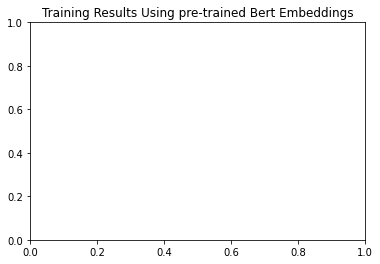

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
titles = []

plt.title("Training Results Using pre-trained Bert Embeddings")
for i, accuracies in enumerate(bert_story_vector_accuracy_sets):
  plt.scatter(list(range(1,5+1)),accuracies)
  titles.append("# points selected: "+ str(sizes[i]))
plt.legend(titles)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.figure()
titles = []
plt.title("Training Results Using Gensim Doc2Vec embeddings")
for i, accuracies in enumerate(gensim_story_vector_accuracy_sets):
  plt.scatter(list(range(1,5+1)),accuracies)
  titles.append("gensim # points selected: "+ str(sizes[i]))
plt.legend(titles)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.figure()
titles = []
plt.title("Training Results Using randomly Selected Vectors")
for i, accuracies in enumerate(random_accuracy_sets):
  plt.scatter(list(range(1,5+1)),accuracies)
  titles.append("random # points selected: "+ str(sizes[i]))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(titles)
plt.show()

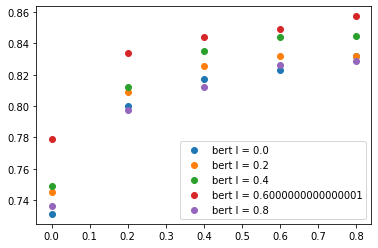

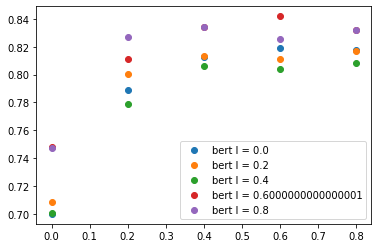

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
titles = []

for i, accuracies in enumerate(bert_accuracies_l):
  plt.scatter(ls,accuracies)
  titles.append("bert l = "+ str(ls[i]))
plt.legend(titles)
plt.figure()


for i, accuracies in enumerate(gensim_accuracies_l):
  plt.scatter(ls,accuracies)
  titles.append("gensim l = "+ str(ls[i]))
plt.legend(titles)

plt.show()

Important Remarks Not to Forget


*   Using Basic Pooler is bad, must do average pool
*   Faster Submodular optimizer is important
*   need to keep V on GPU





What do do next 

*   Generate Data With Dumplicate information ie replace names and some verbs maybe

*   Inverse document summarization vector (SIF) or traditional embeddings









THINGS To record and use for research

*   Accuracies given sizes of data
*   plots for each size of data but compare 3 different stratagies on each plot
*   training times given size of data
*   turning of l




